# DeepDream

DeepDream 是一种使用卷积神经网络学到的表示进行艺术图像修改的技术。它首次由谷歌在2015年的夏天发布，其使用 Caffe深度学习库编写（这是TensorFlow首次公开发布之前的几个月）。它的出现轰动一时， 因为它能够生成 trippy 的图像。 这种图像充满了 pareidolia artifacts, bird feathers, 和 dog eyes —— DeepDream 在 ImageNet 上训练，狗和鸟的种类非常多。

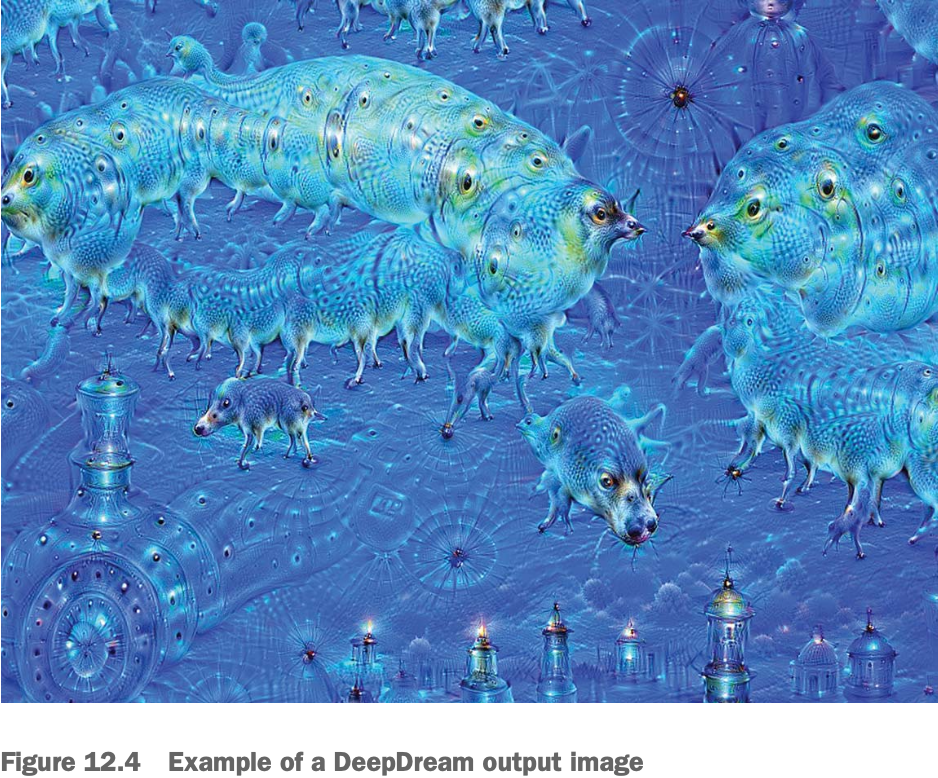

DeepDream算法与第9章中介绍的convnet filter可视化技术几乎相同，包括反向运行convnet：对convnet的输入进行梯度提升，以最大限度地激活convnet上层的特定滤波器。DeepDream使用同样的想法，有几个简单的区别：

- 使用DeepDream，您可以尝试最大化整个层的激活，而不是特定 filter 的激活，从而同时将大量功能的可视化混合在一起。
- 您不是从空白、略带嘈杂的输入开始，而是从现有图像开始——因此，由此产生的效果以某种艺术的方式锁定到先前存在的视觉模式，扭曲图像的元素。
- 输入图像以不同的尺度（称为 octaves）进行处理，这提高了可视化质量。

## 12.2.1 Implementing DeepDream in Keras

让我们从检索要 dream 的测试图像开始。冬天，我们将欣赏崎岖的北加州海岸（图12.5）。

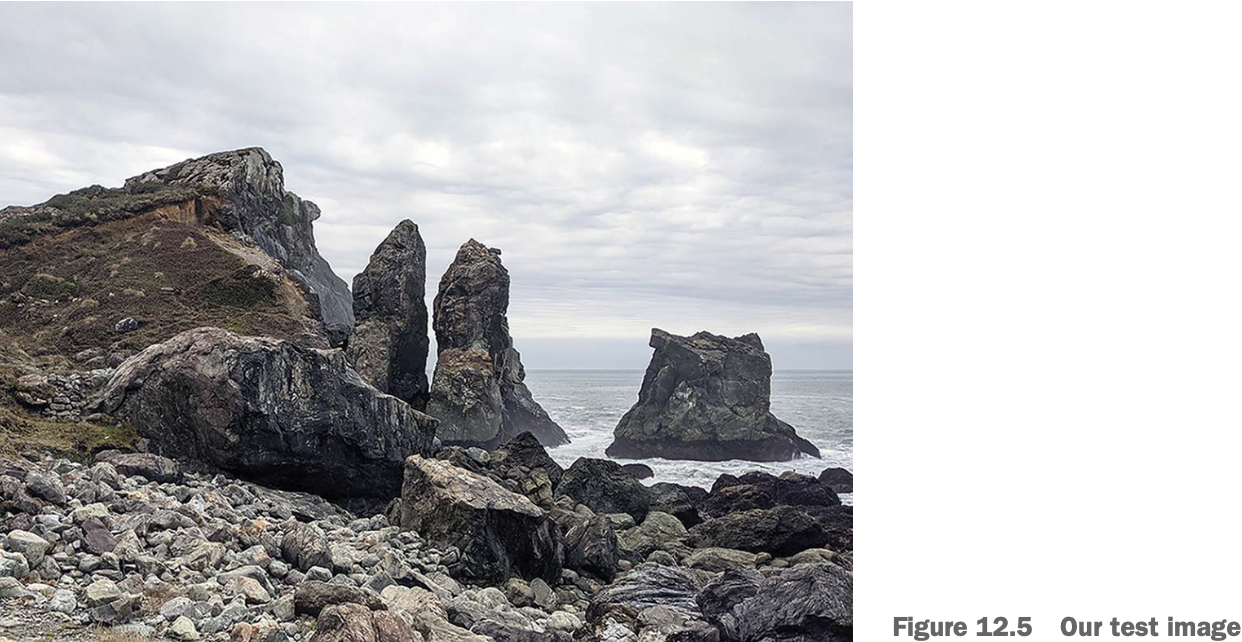

450560/440742 [==============================] - 1s 2us/step


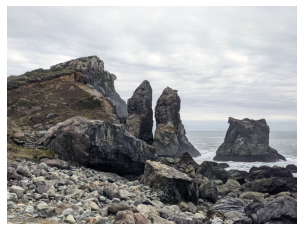

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
)
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

接下来，我们需要一个预训练的卷积网络。在Keras中，有许多这样的convnet：VGG16、VGG19、Xception、ResNet50等，所有这些都有ImageNet上的预训练权重。您可以使用其中任何一个实现DeepDream，但您选择的基本模型会影响您的可视化，因为不同的架构会导致不同的学习功能。原始DeepDream版本中使用的convnet是Inception模型，在实践中，Inception以生产漂亮的DeepDreams而闻名，因此我们将使用Keras附带的Inception V3模型。

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

2022-04-05 15:28:18.472456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 15:28:18.473281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
87924736/87910968 [==============================] - 19s 0us/step


我们将使用预训练的convnet创建一个T恩正提取模型，该模型返回以下代码中列出的各个中间层的激活。对于每一层，我们选择一个标量分数，该分数权衡该层对我们在梯度上升过程中寻求最大化的损失的贡献。

如果您想要一个 可用于选择新层的层名称的列表，只需使用model.summary()。

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name)
            for name in layer_settings.keys()]
    ] 
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

接下来，我们将计算损失：在每个处理规模的梯度上升过程中，我们将寻求最大的数量。在第9章中，对于 filter 可视化，我们试图最大化特定层中特定 filter 的值。在这里，我们将同时最大限度地激活多个层中的所有 filter。 具体来说，我们将最大化一组高层激活的L2范数的加权平均值。我们选择的确切层集（及其对最终损失的贡献）对我们能够生成的视觉效果有重大影响，因此我们希望使这些参数易于配置。较低的层产生几何图案，而较高的层产生视觉效果，您可以在其中识别ImageNet的某些类别（例如鸟类或狗）。我们将从有点随意的配置开始——但您以后肯定会想探索许多不同的配置。

In [5]:
def compute_loss(input_image):
    features = feature_extractor(input_image) 
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # 通过只包含非边界的像素避免 border artifacts
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

现在，让我们设置梯度上升过程，我们将在每个 octave 上运行。你会意识到这与第9章中的 fiter 可视化技术是一回事！DeepDream算法只是一种多尺度的 filter 可视化形式。

In [7]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape: 
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image) 
    grads = tf.math.l2_normalize(grads) 
    image += learning_rate * grads 
    return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

最后，DeepDream算法的外循环。首先，我们将定义一个处理图像的 scales 列表（也称为 octave）。我们将通过三个不同的 “octave” 处理我们的图像。对于每个连续的 octave，从最小到最大，我们将通过 gradient_ascent_loop() 运行20个梯度上升步骤，以最大化我们之前定义的损失。在每个 octave 之间，我们将图像 upscale 40%(1.4倍): 我们将首先处理一张小图像，然后越来越多地放大（见图12.6）。

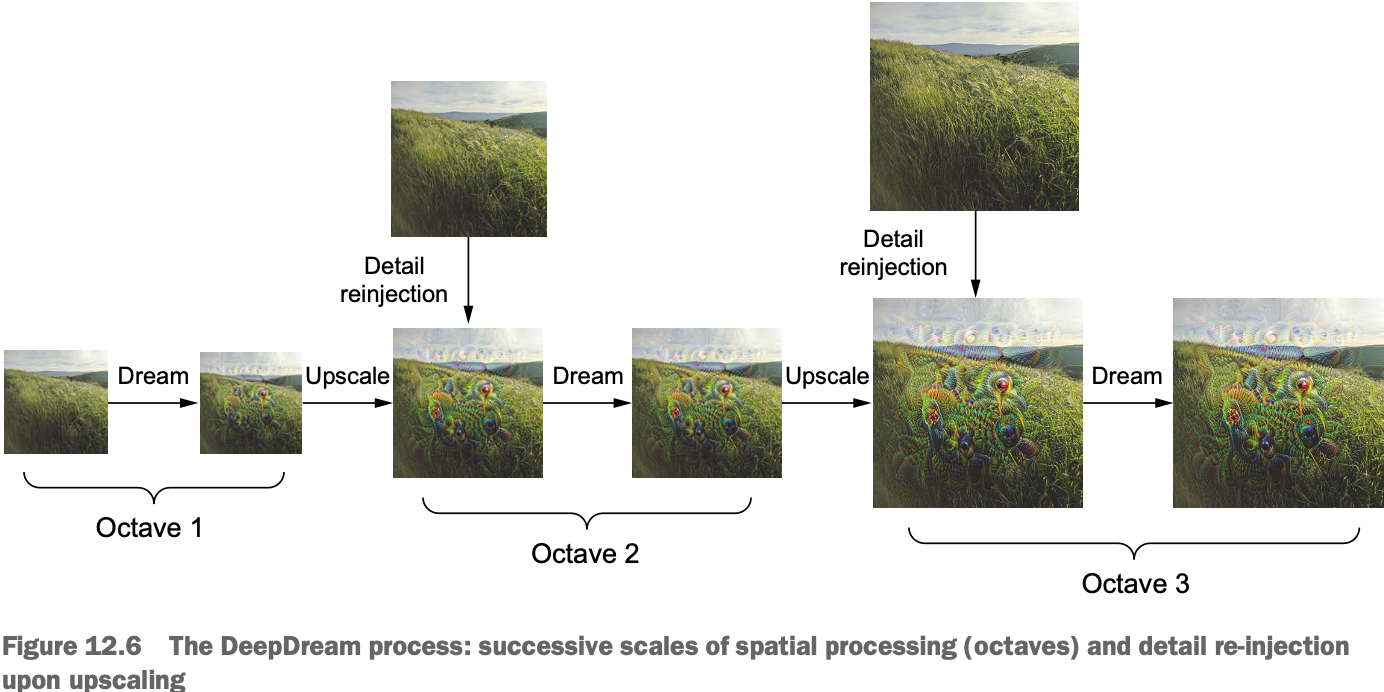

我们在以下代码中定义了此过程的参数。调整这些参数将允许您实现新的效果！

In [8]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

我们还需要几个函数来加载和保存图像。

In [10]:
import numpy as np
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img) 
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8") 
    return img

这是外层循环。为了避免在每次连续 scale-up 后丢失大量图像细节（导致图像越来越模糊或像素化），我们可以使用一个简单的技巧：每次放大后，我们都会将丢失的细节重新注入图像中，因为我们知道原始图像在更大的比例下应该是什么样子。给定较小的图像大小S和较大的图像大小L，我们可以计算原始图像调整为大小L和原始调整为大小S之间的差异——这种差异量化了从S到L时丢失的详细信息。

In [12]:
original_img = preprocess_image(base_image_path)
# Compute the target shape of the image at different octaves.
original_shape = original_img.shape[1:3]

# 
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

#  Make a copy of the image (we need to keep the original around).
img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}") 
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss 
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)
    
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))


Processing octave 0 with shape (459, 612)


2022-04-05 16:07:47.349067: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-05 16:07:47.359820: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-05 16:07:47.361806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.15
... Loss value at step 5: 2.47
... Loss value at step 6: 2.84
... Loss value at step 7: 3.18
... Loss value at step 8: 3.52
... Loss value at step 9: 3.88
... Loss value at step 10: 4.21
... Loss value at step 11: 4.62
... Loss value at step 12: 4.97
... Loss value at step 13: 5.33
... Loss value at step 14: 5.66
... Loss value at step 15: 6.04
... Loss value at step 16: 6.34
... Loss value at step 17: 6.73
... Loss value at step 18: 7.03
... Loss value at step 19: 7.40
... Loss value at step 20: 7.70
... Loss value at step 21: 8.05
... Loss value at step 22: 8.31
... Loss value at step 23: 8.65
... Loss value at step 24: 8.91
... Loss value at step 25: 9.20
... Loss value at step 26: 9.49
... Loss value at step 27: 9.84
... Loss value at step 28: 10.08
... Loss value at step 29: 10.32
Processing octave 1 with shape (642, 857)


2022-04-05 16:07:54.600293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.56
... Loss value at step 1: 2.57
... Loss value at step 2: 3.35
... Loss value at step 3: 3.95
... Loss value at step 4: 4.49
... Loss value at step 5: 5.00
... Loss value at step 6: 5.50
... Loss value at step 7: 5.91
... Loss value at step 8: 6.38
... Loss value at step 9: 6.81
... Loss value at step 10: 7.20
... Loss value at step 11: 7.54
... Loss value at step 12: 7.98
... Loss value at step 13: 8.17
... Loss value at step 14: 8.60
... Loss value at step 15: 8.72
... Loss value at step 16: 9.18
... Loss value at step 17: 9.40
... Loss value at step 18: 9.79
... Loss value at step 19: 10.02
... Loss value at step 20: 10.62
... Loss value at step 21: 10.67
... Loss value at step 22: 11.23
... Loss value at step 23: 11.30
... Loss value at step 24: 11.93
... Loss value at step 25: 11.93
... Loss value at step 26: 12.53
... Loss value at step 27: 12.83
... Loss value at step 28: 13.28
... Loss value at step 29: 13.53
Processing octave 2 with shape (900, 12

2022-04-05 16:08:01.651397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.40
... Loss value at step 1: 2.16
... Loss value at step 2: 2.79
... Loss value at step 3: 3.29
... Loss value at step 4: 3.77
... Loss value at step 5: 4.23
... Loss value at step 6: 4.69
... Loss value at step 7: 5.12
... Loss value at step 8: 5.56
... Loss value at step 9: 6.04
... Loss value at step 10: 6.33
... Loss value at step 11: 6.73
... Loss value at step 12: 6.99
... Loss value at step 13: 7.63
... Loss value at step 14: 7.87
... Loss value at step 15: 8.44
... Loss value at step 16: 8.68
... Loss value at step 17: 9.30
... Loss value at step 18: 9.45
... Loss value at step 19: 10.10
... Loss value at step 20: 10.27
... Loss value at step 21: 10.75
... Loss value at step 22: 11.02
... Loss value at step 23: 11.64
... Loss value at step 24: 11.98
... Loss value at step 25: 12.43
... Loss value at step 26: 12.88
... Loss value at step 27: 13.17
... Loss value at step 28: 13.69
... Loss value at step 29: 14.05


**Note：** 由于原始经过预训练的 Inception V3 网络，可以识别 299×299 大小图像中的concept，并且鉴于该过程涉及以合理的系数缩放图像，DeepDream实现在 300×300 至 400×400 之间的图像上产生了更好的结果。您可以在任何大小和任何比例的图像上运行相同的代码。

在GPU上，只需几秒钟即可运行整个过程。图12.7显示了我们在测试图像上的 dream 配置结果。

我强烈建议您通过调整您在损失中使用的层来探索您可以做些什么。网络中较低的层包含更多本地、更少抽象的表示，并产生看起来更几何的 dream 模式。较高的层产生基于最常见目标的更易于识别 ImageNet 中的视觉模式， 例如 dog eyes, bird feathers 等等。 您可以使用 layer_settings 典中参数的随机生成来快速探索许多不同的层组合。图12.8显示了使用不同层配置的美味糕点图像获得的一系列结果。

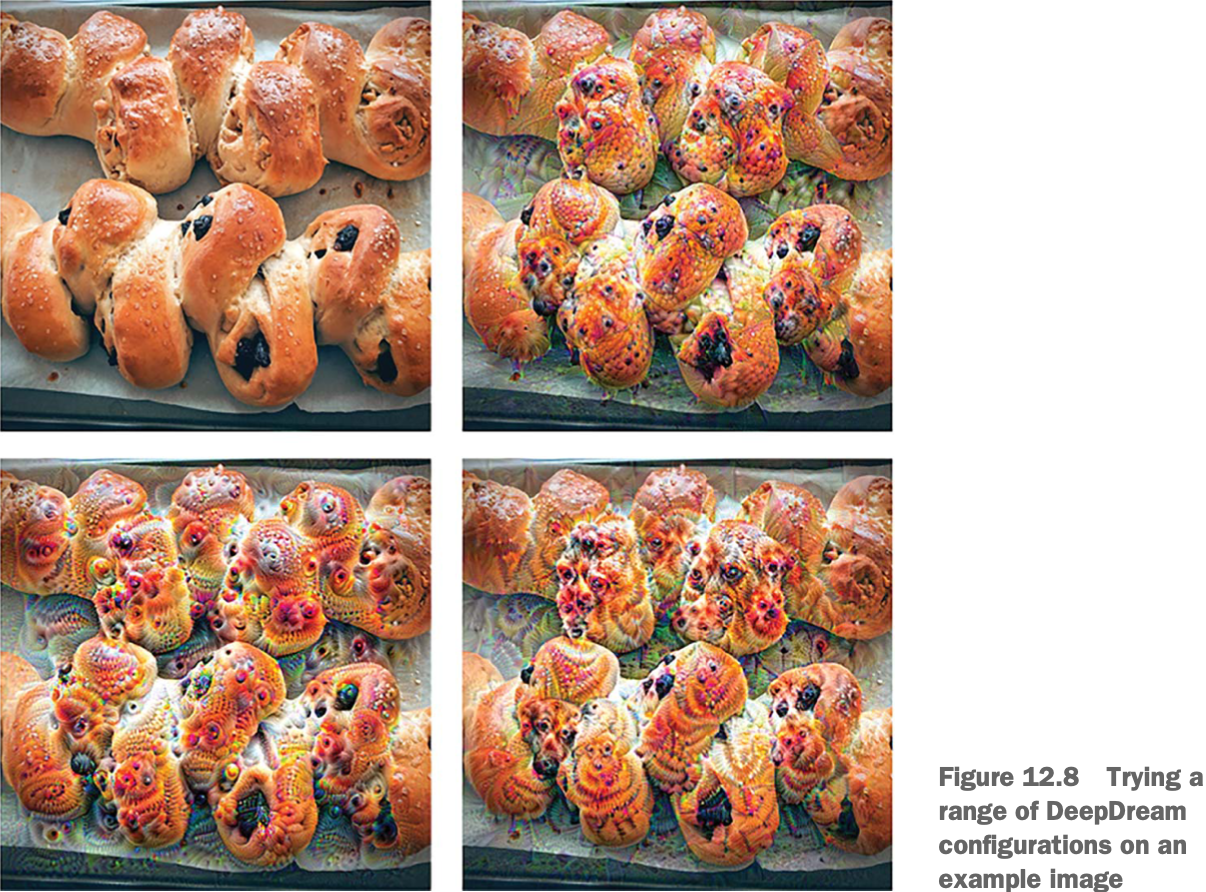



## 12.2.2 Wrapping up

- DeepDream 反向运行convnet，以根据网络学到的表示生成输入。
- 产生的结果很有趣，与通过 psychedelics 破坏视觉皮层在人类中诱导的视觉伪影有些相似。
- 请注意，该过程并非特定于图像模型，甚至不特定于convnet。它可以用于演讲、音乐等。

